In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
mnist = fetch_openml('mnist_784', version=1) #carregando dataset mnist
mnist.keys() #mostrando chaves "pra iterações"

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"] # X (Matriz) recebe os dados e y (vetor) recebe as respostas
X.shape #mostrando dimensão de X (matriz)

(70000, 784)

In [4]:
y.shape #mostrando dimensão de y

(70000,)

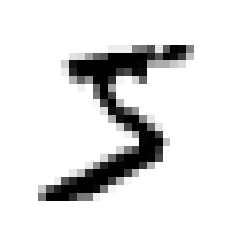

In [5]:
n = 0
some_digit = X[n] #variável recebe um dado (índice n) da Matriz X 
some_digit_image = some_digit.reshape(28, 28) #por padrão as imagens para são 28 por 28

plt.imshow(some_digit_image, cmap="binary") # cmap='binary' => escala cinza
plt.axis("off") #sem eixos, só imagem
plt.show()

In [6]:
y[n] #até aqui a resposta ainda era string, pra voltar tem que definir o Conjunto X de novo ou mudar o tipo com np.astype(str)

'5'

In [7]:
type(y[n]) #retorna o tipo da variável

str

In [8]:
y = y.astype(np.uint8) #converter y para número (permanente)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #separando conjunto de treino e teste

In [10]:
#conjunto de teste de método
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [11]:
sgd_clf = SGDClassifier(random_state=42) #definindo sgd_clf como o método gradiente descendente
sgd_clf.fit(X_train, y_train_5) #ajustando o conjunto de dados ao método

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
n = 0 # mostrando qual dígito está na posição zero
y_train[n]

5

In [13]:
sgd_clf.predict([X_train[n]]) #testando gradiente descendente na posição zero

array([ True])

In [14]:
def plot_digits(instances, images_per_row=10, **options): #Configurando Mnist pra plotar
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

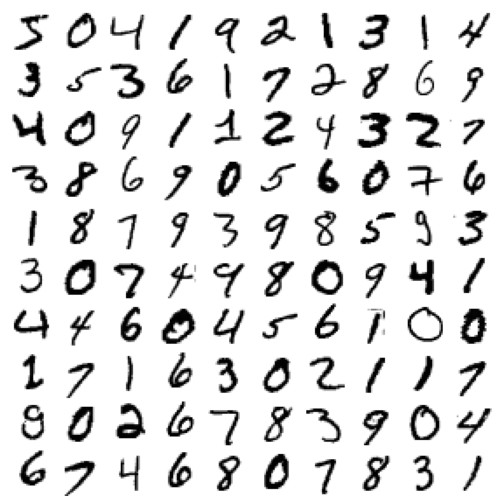

In [15]:
plt.figure(figsize=(9,9)) #plotando digitos do Mnist
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [16]:
print(y_train[n]) #Teste SGD
n = 0
if sgd_clf.predict([X_train[n]]):
    print('You done well!')
else:
    print('Go spend your time studying more!')


5
You done well!


In [18]:
# Fazendo a validação cruzada com amostragem estratificada e printando ratio de predições corretas

# At each iteration the code creates a clone of the classifier, trains that clone on the training folds,
# and makes predictions on the test fold. Then it counts the number of correct predictions and output
# the ratio of correct predictions.

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565, and 0.96495

c:\users\yurik\desktop\projeto handson\my_env\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") #acessando score do SKfold

array([0.95035, 0.96035, 0.9604 ])

In [20]:
class Never5Classifier(BaseEstimator): #criando classe pra aplicar método de 5 ou não 5 (chamado de classificador "burro")
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") #printando scores de SKFold em never5


array([0.91125, 0.90855, 0.90915])

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #armazenando as predições em y_train_pred

In [23]:
confusion_matrix(y_train_5, y_train_pred) #imprimindo matriz de confusão

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [24]:
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687) **precisão**

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891) **sensitividade**

0.6511713705958311

In [26]:
f1_score(y_train_5, y_train_pred) # outra métrica de performance usando média harmônica

0.7325171197343846

In [27]:
y_scores = sgd_clf.decision_function([some_digit]) #Acessando a decision_funcion do método para alterar threshold

In [28]:
y_scores

array([2164.22030239])

In [29]:
threshold = 0 #simulando um valor de treshold

In [30]:
y_some_digit_pred = (y_scores > threshold) #simulando o que o pc faz, se score for maior que threshold : é um 5
y_some_digit_pred

array([ True])

In [31]:
threshold = 8000 #simulando um valor de treshold

In [32]:
#simulando o que o pc faz, se score for maior que threshold : é um 5, aumentou muito o threshold e deu problema na precisão
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
print(y_train[n]) # confirmando que o algorítmo errou

5


In [34]:
# código para obter todos os scores de todas instancias no grupo de treinamento,
# só que o método é configurado para retornar os scores de decisões ao invés das predições
# e armazena todos scores de decisões em: y_scores

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function") #sem inclur method retorna as predições

In [35]:
y_scores #imprime scores de decisões

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [36]:
#teste com methods default: y_scores_verif recebe as predições

y_scores_verif = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [37]:
y_scores_verif #imprime as predições

array([ True, False, False, ...,  True, False, False])

In [38]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) #obtem valores de precisão, recall e threshold

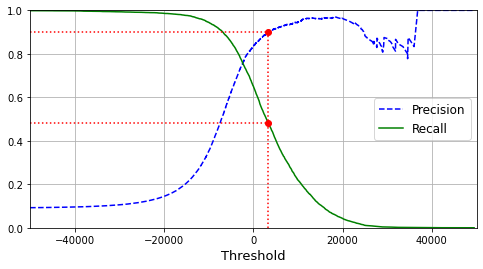

In [39]:
#plotando gráfico com precisão, recall e threshold

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=1.5)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=1.5)
    plt.legend(loc="center right", fontsize=12) # Not shown in the book
    plt.xlabel("Threshold", fontsize=13)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # retorna o primeiro valor que resulta em 90% de precisão
threshold_90_precision

3370.0194991439557

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision) #faz o treinamento com o threshold certo pra retorna 90% de precisão

In [42]:
precision_score(y_train_5, y_train_pred_90) #testando precisão

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [44]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

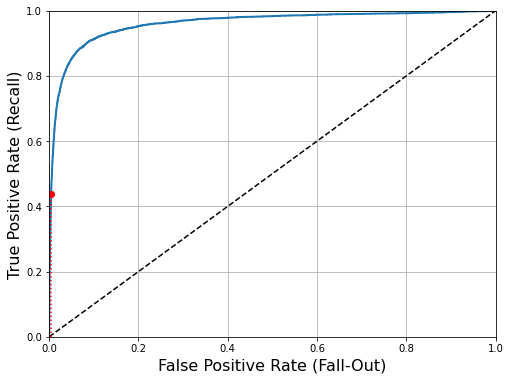

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
#save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [48]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [50]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [51]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

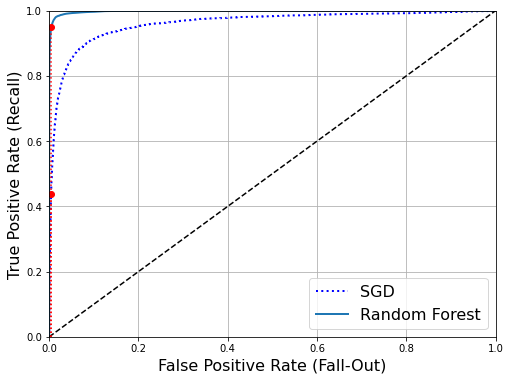

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145